In [36]:
import json
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import dns.resolver

RESULTS_PATH = pathlib.Path("results.jsonl")
BLOCKLIST_PATH = pathlib.Path("services.json")
ENTITIES_PATH = pathlib.Path("entities.json")


def load_results(path: pathlib.Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    visits, requests = [], []
    with path.open("r", encoding="utf-8") as handle:
        for line in handle:
            record = json.loads(line)
            visits.append(
                {
                    "visit_id": record["visit_id"],
                    "crawl_mode": record.get("crawl_mode"),
                    "consent_action": record.get("consent_action"),
                    "country": record.get("country"),
                    **record.get("summary", {}),
                }
            )
            for req in record.get("requests", []):
                requests.append(
                    {
                        "visit_id": record["visit_id"],
                        "crawl_mode": record.get("crawl_mode"),
                        "url": req.get("url"),
                        "status": req.get("status"),
                        "is_third_party": req.get("is_third_party"),
                        "disconnect_category": req.get("disconnect_category"),
                        "resourceType": req.get("resourceType"),
                        "blocked": req.get("blocked"),
                        "time": req.get("time"),
                        "ipAddress": req.get("ipAddress"),
                        "response_headers": req.get("response_headers"),
                        "redirect_url": req.get("redirectURL"),
                    }
                )
    return pd.DataFrame(visits), pd.DataFrame(requests)

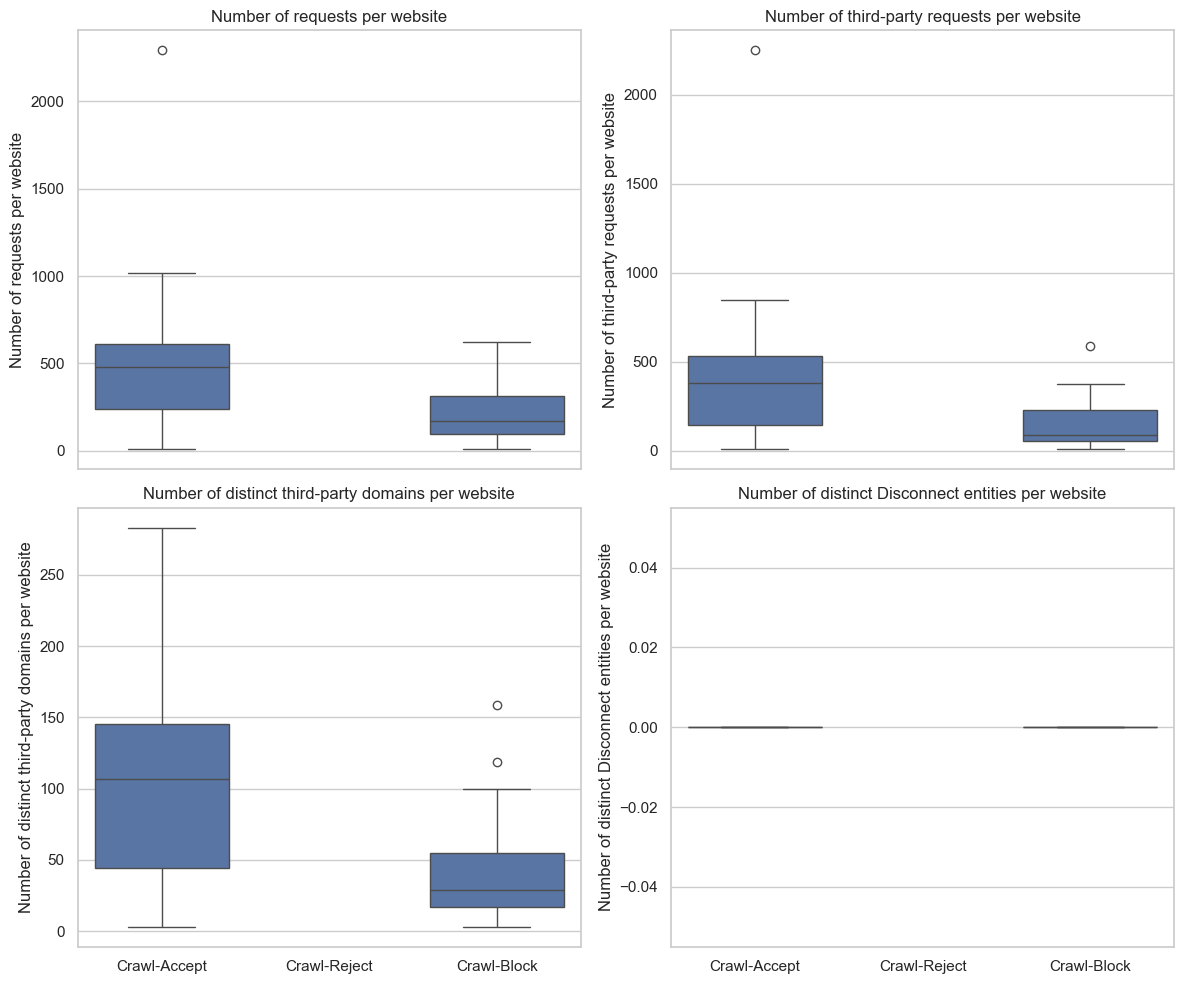

In [37]:
# 1

visits_df, _ = load_results(RESULTS_PATH)

label_map = {"accept": "Crawl-Accept", "reject": "Crawl-Reject", "block": "Crawl-Block"}
visits_df = visits_df.assign(
    crawl_label=visits_df["crawl_mode"].map(label_map),
    distinct_entities=visits_df["disconnect_category_counts"].apply(
        lambda d: len(d) if isinstance(d, dict) else 0
    ),
)

metrics = [
    ("total_requests", "Number of requests per website"),
    ("third_party_requests", "Number of third-party requests per website"),
    ("unique_domains_third_party", "Number of distinct third-party domains per website"),
    ("distinct_entities", "Number of distinct Disconnect entities per website"),
]

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True)

for ax, (col, title) in zip(axes.flat, metrics):
    if col not in visits_df:
        raise KeyError(f"Missing summary column: {col}")
    sns.boxplot(
        data=visits_df,
        x="crawl_label",
        y=col,
        order=["Crawl-Accept", "Crawl-Reject", "Crawl-Block"],
        ax=ax,
    )
    ax.set_xlabel("")
    ax.set_ylabel(title)
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [38]:
# 2

metrics = {
    "total_requests": "Number of requests per website",
    "third_party_requests": "Number of third-party requests per website",
    "unique_domains_third_party": "Number of distinct third-party domains per website",
    "distinct_entities": "Number of distinct Disconnect entities per website",
}

stats = ["min", "median", "max"]

summary = (
    visits_df.groupby("crawl_label")[list(metrics.keys())]
    .agg(stats) # type: ignore
    .rename_axis(index="Crawl")
)

summary.columns = [f"{metrics[col]} – {stat.title()}" for col, stat in summary.columns]
summary

,Number of requests per website – Min,Number of requests per website – Median,Number of requests per website – Max,Number of third-party requests per website – Min,Number of third-party requests per website – Median,Number of third-party requests per website – Max,Number of distinct third-party domains per website – Min,Number of distinct third-party domains per website – Median,Number of distinct third-party domains per website – Max,Number of distinct Disconnect entities per website – Min,Number of distinct Disconnect entities per website – Median,Number of distinct Disconnect entities per website – Max
Crawl,,,,,,,,,,,,
Crawl-Accept,13,481.5,2291,8,378.0,2250,3,107.0,283,0,0.0,0
Crawl-Block,8,173.5,620,6,87.0,586,3,29.0,159,0,0.0,0


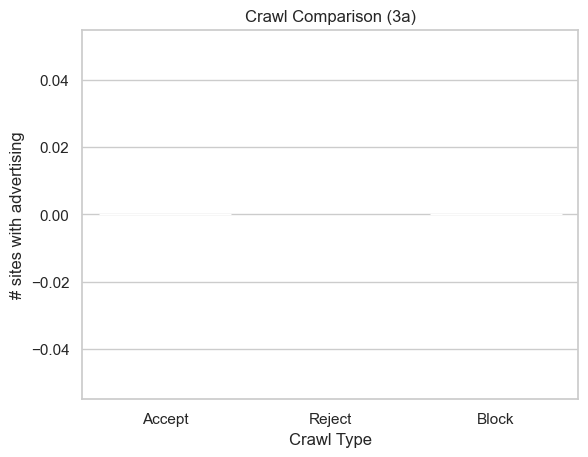

In [39]:
# 3a

visits_df, requests_df = load_results(RESULTS_PATH)
label_map = {"accept": "Accept", "reject": "Reject", "block": "Block"}
visits_df = visits_df.assign(crawl_label=visits_df["crawl_mode"].map(label_map))

advertising_visits = (
    requests_df[requests_df["disconnect_category"] == "Advertising"]["visit_id"]
    .dropna()
    .unique()
)

summary = (
    visits_df.assign(has_advertising=visits_df["visit_id"].isin(advertising_visits))
    .groupby("crawl_label")["has_advertising"]
    .sum()
    .reindex(["Accept", "Reject", "Block"])
    .rename("# sites with advertising")
)

# Turn the Series into a DataFrame for seaborn
summary_df = (
    summary
    .reset_index()
    .rename(columns={"crawl_label": "Crawl Type", "# sites with advertising": "Sites with advertising"})
)

sns.set_theme(style="whitegrid")
ax = sns.barplot(
    data=summary_df,
    x="Crawl Type",
    y="Sites with advertising",
    hue="Crawl Type", 
    palette=["#4C72B0", "#DD8452", "#55A868"],
    legend=False,       
)

ax.set_xlabel("Crawl Type")
ax.set_ylabel("# sites with advertising")
ax.set_title("Crawl Comparison (3a)")
plt.show()

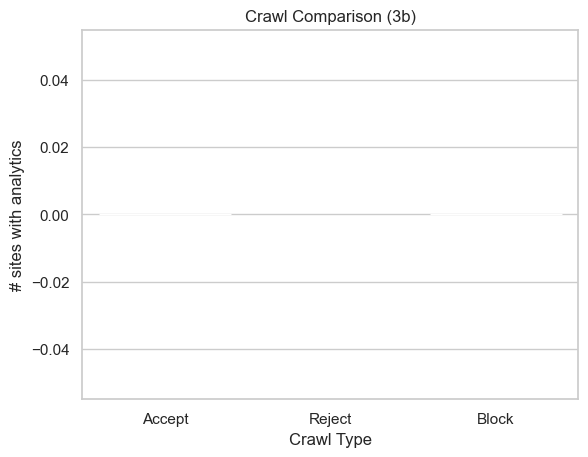

In [40]:
# 3b

visits_df, requests_df = load_results(RESULTS_PATH)
label_map = {"accept": "Accept", "reject": "Reject", "block": "Block"}
visits_df = visits_df.assign(crawl_label=visits_df["crawl_mode"].map(label_map))

analytics_visits = (
    requests_df[requests_df["disconnect_category"] == "Analytics"]["visit_id"]
    .dropna()
    .unique()
)

summary = (
    visits_df.assign(has_analytics=visits_df["visit_id"].isin(analytics_visits))
    .groupby("crawl_label")["has_analytics"]
    .sum()
    .reindex(["Accept", "Reject", "Block"])
    .rename("# sites with analytics")
)

# Convert Series into a DataFrame for seaborn
summary_df = (
    summary
    .reset_index()
    .rename(columns={"crawl_label": "Crawl Type",
                     "# sites with analytics": "Sites with analytics"})
)

sns.set_theme(style="whitegrid")
ax = sns.barplot(
    data=summary_df,
    x="Crawl Type",
    y="Sites with analytics",
    hue="Crawl Type",   # explicitly link palette to variable
    palette=["#4C72B0", "#DD8452", "#55A868"],
    legend=False,
)

ax.set_xlabel("Crawl Type")
ax.set_ylabel("# sites with analytics")
ax.set_title("Crawl Comparison (3b)")
plt.show()

In [41]:
# 4

visits_all, _ = load_results(RESULTS_PATH)
visits_all = visits_all.assign(
    distinct_entities=visits_all["disconnect_category_counts"].apply(
        lambda d: len(d) if isinstance(d, dict) else 0
    )
)

metrics = {
    "total_requests": "Number of requests per website",
    "third_party_requests": "Number of third-party requests per website",
    "unique_domains_third_party": "Number of distinct third-party domains per website",
    "distinct_entities": "Number of distinct Disconnect entities per website",
}
for col in metrics:
    visits_all[col] = pd.to_numeric(visits_all[col], errors="coerce")

us_countries = {"US"}
eu_countries = {"DE", "FR", "NL", "BE", "ES", "IT", "PT", "SE", "DK", "NO", "FI", "IE", "AT", "CH"}

accept_df = visits_all[visits_all["crawl_mode"] == "accept"].copy()
accept_df["region"] = accept_df["country"].str.upper().map(
    lambda c: "US News Sites" if c in us_countries else ("European News Sites" if c in eu_countries else None)
)

stats = ["min", "median", "max"]
summary_us_eu = (
    accept_df.dropna(subset=["region"])
    .groupby("region")[list(metrics.keys())]
    .agg(stats) # type: ignore
    .rename_axis(index="Metric group")
    .transpose()
)

summary_us_eu.index = [
    f"{metrics[col]} – {stat.title()}" for col, stat in summary_us_eu.index
]
regions = ["US News Sites", "European News Sites"]
summary_us_eu = summary_us_eu.reindex(columns=regions)
summary_us_eu.loc[:, regions]

Metric group,US News Sites,European News Sites
Number of requests per website – Min,13.0,50.0
Number of requests per website – Median,379.5,498.0
Number of requests per website – Max,2291.0,824.0
Number of third-party requests per website – Min,10.0,8.0
Number of third-party requests per website – Median,271.0,455.0
Number of third-party requests per website – Max,2250.0,801.0
Number of distinct third-party domains per website – Min,3.0,4.0
Number of distinct third-party domains per website – Median,91.5,135.0
Number of distinct third-party domains per website – Max,283.0,190.0
Number of distinct Disconnect entities per website – Min,0.0,0.0


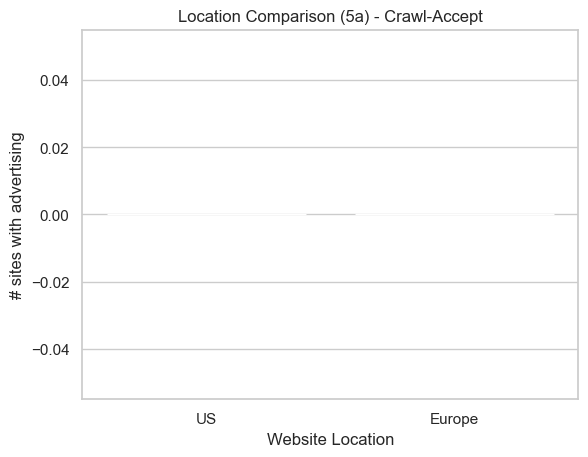

In [42]:
# 5a

visits_accept, requests_accept = load_results(RESULTS_PATH)
visits_accept = visits_accept.assign(
    distinct_entities=visits_accept["disconnect_category_counts"].apply(
        lambda d: len(d) if isinstance(d, dict) else 0
    )
)

us_countries = {"US"}
eu_countries = {"DE", "FR", "NL", "BE", "ES", "IT", "PT", "SE", "DK", "NO", "FI", "IE", "AT", "CH"}

accept_only = visits_accept[visits_accept["crawl_mode"] == "accept"].copy()
accept_only["region"] = accept_only["country"].str.upper().map(
    lambda c: "US" if c in us_countries else ("Europe" if c in eu_countries else None)
)

advertising_visits_accept = (
    requests_accept[
        (requests_accept["crawl_mode"] == "accept")
        & (requests_accept["disconnect_category"] == "Advertising")
    ]["visit_id"]
    .dropna()
    .unique()
)

summary_5a = (
    accept_only.assign(has_ads=accept_only["visit_id"].isin(advertising_visits_accept))
    .dropna(subset=["region"])
    .groupby("region")["has_ads"]
    .sum()
    .reindex(["US", "Europe"])
    .rename("# sites with advertising")
)

# Convert Series into a DataFrame for seaborn
summary_5a_df = (
    summary_5a
    .reset_index()
    .rename(columns={"region": "Region", "# sites with advertising": "Sites with advertising"})
)

sns.set_theme(style="whitegrid")
ax = sns.barplot(
    data=summary_5a_df,
    x="Region",
    y="Sites with advertising",
    hue="Region",
    palette=["#4C72B0", "#DD8452"],
    legend=False,
)

ax.set_xlabel("Website Location")
ax.set_ylabel("# sites with advertising")
ax.set_title("Location Comparison (5a) - Crawl-Accept")
plt.show()

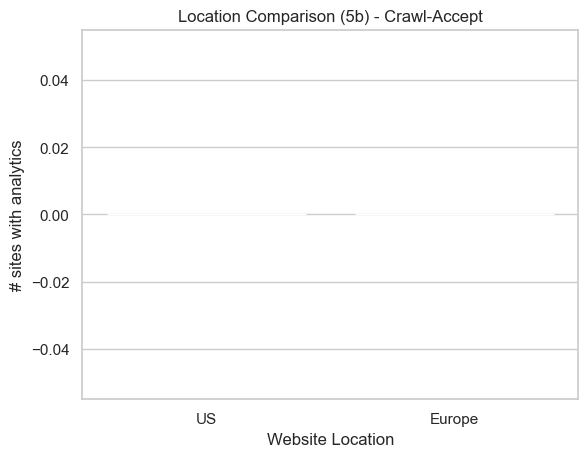

In [43]:
# 5b

visits_accept, requests_accept = load_results(RESULTS_PATH)

us_countries = {"US"}
eu_countries = {"DE", "FR", "NL", "BE", "ES", "IT", "PT", "SE", "DK", "NO", "FI", "IE", "AT", "CH"}

accept_only = visits_accept[visits_accept["crawl_mode"] == "accept"].copy()
accept_only["region"] = accept_only["country"].str.upper().map(
    lambda c: "US" if c in us_countries else ("Europe" if c in eu_countries else None)
)

analytics_visits_accept = (
    requests_accept[
        (requests_accept["crawl_mode"] == "accept")
        & (requests_accept["disconnect_category"] == "Analytics")
    ]["visit_id"]
    .dropna()
    .unique()
)

summary_5b = (
    accept_only.assign(has_analytics=accept_only["visit_id"].isin(analytics_visits_accept))
    .dropna(subset=["region"])
    .groupby("region")["has_analytics"]
    .sum()
    .reindex(["US", "Europe"])
    .rename("# sites with analytics")
)

# Convert Series into a DataFrame for seaborn
summary_5b_df = (
    summary_5b
    .reset_index()
    .rename(columns={"region": "Region", "# sites with analytics": "Sites with analytics"})
)

sns.set_theme(style="whitegrid")
ax = sns.barplot(
    data=summary_5b_df,
    x="Region",
    y="Sites with analytics",
    hue="Region",
    palette=["#4C72B0", "#DD8452"],
    legend=False,
)

ax.set_xlabel("Website Location")
ax.set_ylabel("# sites with analytics")
ax.set_title("Location Comparison (5b) - Crawl-Accept")
plt.show()

In [44]:
# 6

# Load the cookie write logs captured during the Accept crawl.
COOKIE_LOG_DIR = (pathlib.Path.cwd() / ".." / "crawl_data_accept").resolve()

if not COOKIE_LOG_DIR.exists():
    raise FileNotFoundError(f"No cookie log directory at {COOKIE_LOG_DIR}")

# Parse each document.cookie assignment to recover the cookie name and optional domain.
def parse_cookie_assignment(value: str) -> tuple[str | None, str | None]:
    parts = [part.strip() for part in value.split(";")]
    if not parts or "=" not in parts[0]:
        return None, None
    name = parts[0].split("=", 1)[0].strip() or None
    domain_attr = None
    for part in parts[1:]:
        if part.lower().startswith("domain="):
            domain_attr = part.split("=", 1)[1].strip() or None
            break
    return name, domain_attr

client_cookie_rows: list[dict[str, str]] = []

# Traverse every cookie log, extract the assignments, and store normalized rows.
for path in COOKIE_LOG_DIR.glob("*_cookie_writes.json"):
    data = json.loads(path.read_text(encoding="utf-8"))
    site_host = data.get("domain") or path.stem.removesuffix("_cookie_writes")
    # Method: use the instrumented document.cookie records captured during the Accept crawl.
    for entry in data.get("writes", []):
        if not isinstance(entry, dict) or not isinstance(entry.get("value"), str):
            continue
        name, domain_attr = parse_cookie_assignment(entry["value"])
        if not name:
            continue
        client_cookie_rows.append(
            {
                "Cookie name": name,
                "Website": site_host,
                "Cookie domain": domain_attr or site_host,
            }
        )

client_cookie_df = pd.DataFrame(
    client_cookie_rows,
    columns=["Cookie name", "Website", "Cookie domain"],
).drop_duplicates()

if not client_cookie_df.empty:
    client_cookie_df = client_cookie_df.sort_values(["Website", "Cookie name"]).reset_index(drop=True)

client_cookie_df

,Cookie name,Website,Cookie domain
0,_ga,ad.nl,ad.nl
1,_ga_DN0P5D59BT,ad.nl,ad.nl
2,_gcl_au,ad.nl,ad.nl
3,_gd1763155756275_sharedId,ad.nl,www.ad.nl
4,_gd1763155756275_sharedId,ad.nl,ad.nl
...,...,...,...
1509,rpisb,washingtonpost.com,.www.washingtonpost.com
1510,rpisb,washingtonpost.com,.washingtonpost.com
1511,wp_ptads,washingtonpost.com,.washingtonpost.com
1512,wp_s,washingtonpost.com,.washingtonpost.com


In [45]:
# 7: Top third-party domains per crawl

from urllib.parse import urlparse

visits_df, requests_df = load_results(RESULTS_PATH)

# Method: derive third-party hosts from request URLs and aggregate distinct websites per crawl mode.
third_party = requests_df[requests_df["is_third_party"].fillna(False)].copy()
third_party["hostname"] = third_party["url"].map(
    lambda u: urlparse(u).hostname if isinstance(u, str) else None
)
third_party = third_party.dropna(subset=["hostname", "visit_id", "crawl_mode"])

label_map = {
    "accept": "Crawl-Accept",
    "reject": "Crawl-Reject",
    "block": "Crawl-Block"
}

tables: dict[str, pd.DataFrame] = {}

for mode, label in label_map.items():
    subset = third_party[third_party["crawl_mode"] == mode]

    grouped = (
        subset.groupby("hostname")
        .agg(
            distinct_websites=("visit_id", pd.Series.nunique),
            disconnect_categories=(
                "disconnect_category",
                lambda cats: ", ".join(sorted({c for c in cats if c})) or "NA"
            ),
        )
        .reset_index()
        .rename(
            columns={
                "hostname": "Third-party domain",
                "distinct_websites": "Number of distinct websites",
                "disconnect_categories": "Disconnect categories",
            }
        )
        .sort_values("Number of distinct websites", ascending=False)
        .head(10)
        .reset_index(drop=True)  
    )

    tables[label] = grouped

    # Pretty display
    print(f"\nTop 10 third-party domains: {label}")
    display(grouped)


Top 10 third-party domains: Crawl-Accept


,Third-party domain,Number of distinct websites,Disconnect categories
0,pagead2.googlesyndication.com,33,NA
1,securepubads.g.doubleclick.net,30,NA
2,cm.g.doubleclick.net,30,NA
3,ib.adnxs.com,30,NA
4,www.google.com,29,NA
5,match.adsrvr.org,28,NA
6,c.amazon-adsystem.com,27,NA
7,ep1.adtrafficquality.google,27,NA
8,ep2.adtrafficquality.google,27,NA
9,config.aps.amazon-adsystem.com,25,NA



Top 10 third-party domains: Crawl-Reject


,Third-party domain,Number of distinct websites,Disconnect categories



Top 10 third-party domains: Crawl-Block


,Third-party domain,Number of distinct websites,Disconnect categories
0,securepubads.g.doubleclick.net,26,NA
1,www.googletagmanager.com,23,NA
2,pagead2.googlesyndication.com,22,NA
3,c.amazon-adsystem.com,20,NA
4,config.aps.amazon-adsystem.com,16,NA
5,www.google.com,15,NA
6,sb.scorecardresearch.com,14,NA
7,fonts.googleapis.com,14,NA
8,connect.facebook.net,13,NA
9,ib.adnxs.com,12,NA


In [46]:
# 8: Top 10 websites by number of distinct third-party domains per crawl

visits_df, _ = load_results(RESULTS_PATH)

label_map = {
    "accept": "Crawl-Accept",
    "reject": "Crawl-Reject",
    "block": "Crawl-Block",
}

metric_col = "unique_domains_third_party"

top10_by_crawl = {}

for crawl_mode, label in label_map.items():
    subset = (
        visits_df[visits_df["crawl_mode"] == crawl_mode]
        .loc[:, ["visit_id", "country", metric_col]]
        .sort_values(metric_col, ascending=False)
        .head(10)
        .rename(
            columns={
                "visit_id": "Website",
                "country": "Country code",
                metric_col: "Number of distinct third-party domains",
            }
        )
        .reset_index(drop=True)
    )

    if subset.empty:
        continue

    top10_by_crawl[label] = subset

    print(f"\nTop 10 websites by distinct third-party domains: {label}")
    display(subset)


Top 10 websites by distinct third-party domains: Crawl-Accept


,Website,Country code,Number of distinct third-party domains
0,huffpost.com,us,283
1,apnews.com,us,235
2,dailymail.co.uk,uk,213
3,buzzfeed.com,us,193
4,libero.it,it,190
5,gazzetta.it,it,187
6,nypost.com,us,182
7,the-sun.com,uk,162
8,nltimes.nl,nl,151
9,corriere.it,it,149



Top 10 websites by distinct third-party domains: Crawl-Block


,Website,Country code,Number of distinct third-party domains
0,huffpost.com,us,159
1,apnews.com,us,119
2,lefigaro.fr,fr,100
3,nypost.com,us,98
4,nbcnews.com,us,87
5,msnbc.com,us,82
6,businessinsider.com,us,71
7,dailymail.co.uk,uk,66
8,bloomberg.com,us,62
9,gazzetta.it,it,56


In [47]:
# 9: Top 10 websites by number of distinct destination server IPs across all crawls

visits_df, requests_df = load_results(RESULTS_PATH)

# Compute unique IPs per visit
ip_counts = (
    requests_df
    .dropna(subset=["ipAddress"])
    .groupby("visit_id")["ipAddress"]
    .nunique()
    .rename("unique_server_ips")
)

# Merge into visit-level data
visits_with_ips = visits_df.merge(ip_counts, on="visit_id", how="left")
visits_with_ips["unique_server_ips"] = (
    visits_with_ips["unique_server_ips"].fillna(0).astype(int)
)

# Now rank across all crawls
top10_all = (
    visits_with_ips
    .loc[:, ["visit_id", "country", "unique_server_ips"]]
    .sort_values("unique_server_ips", ascending=False)
    .head(10)
    .rename(
        columns={
            "visit_id": "Website",
            "country": "Country code",
            "unique_server_ips": "Number of distinct destination server IPs",
        }
    )
    .reset_index(drop=True)
)

print("Top 10 websites by distinct destination server IPs across all crawls")
display(top10_all)

Top 10 websites by distinct destination server IPs across all crawls


,Website,Country code,Number of distinct destination server IPs
0,huffpost.com,us,287
1,huffpost.com,us,287
2,apnews.com,us,229
3,apnews.com,us,229
4,dailymail.co.uk,uk,222
5,dailymail.co.uk,uk,222
6,nypost.com,us,199
7,nypost.com,us,199
8,gazzetta.it,it,183
9,gazzetta.it,it,183


In [48]:
# 10: Permissions-Policy: top 5 completely disabled permissions per crawl

from collections import defaultdict

visits_df, requests_df = load_results(RESULTS_PATH)

def extract_disabled_permissions(header_value: str) -> set[str]:
    # Parse a Permissions-Policy header and return permissions that are completely disabled
    disabled = set()
    if not isinstance(header_value, str):
        return disabled

    # Typical format: "camera=(), geolocation=(self), microphone=()"
    for directive in header_value.split(","):
        directive = directive.strip()
        if not directive or "=" not in directive:
            continue

        name, rest = directive.split("=", 1)
        name = name.strip()

        open_paren = rest.find("(")
        close_paren = rest.find(")", open_paren + 1)
        if open_paren == -1 or close_paren == -1:
            continue

        inner = rest[open_paren + 1 : close_paren].strip()
        # inner == "" ⇒ feature=()
        if inner == "":
            disabled.add(name)

    return disabled


# permission_sites_by_crawl[crawl_mode][permission] = set of visit_ids
permission_sites_by_crawl: dict[str, dict[str, set[str]]] = defaultdict(
    lambda: defaultdict(set)
)

num_requests_with_perm = 0

for _, row in requests_df.iterrows():
    headers = row.get("response_headers")
    if not isinstance(headers, dict):
        continue

    header_val = headers.get("permissions-policy") or headers.get("Permissions-Policy")
    if not header_val:
        continue

    # If header is a list, join the values
    if isinstance(header_val, list):
        header_val = ", ".join(str(v) for v in header_val)

    num_requests_with_perm += 1

    disabled_perms = extract_disabled_permissions(header_val)
    if not disabled_perms:
        continue

    visit_id = row["visit_id"]
    crawl_mode = row.get("crawl_mode")
    if crawl_mode is None:
        continue

    for perm in disabled_perms:
        permission_sites_by_crawl[crawl_mode][perm].add(visit_id)

print("Requests with a Permissions-Policy header:", num_requests_with_perm)

label_map = {
    "accept": "Crawl-Accept",
    "reject": "Crawl-Reject",
    "block": "Crawl-Block",
}

perm_top5_by_crawl = {}

for crawl_mode, label in label_map.items():
    perm_map = permission_sites_by_crawl.get(crawl_mode, {})
    if not perm_map:
        print(f"\nNo Permissions-Policy data for {label}.")
        continue

    summary_rows = [
        {
            "Permission": perm,
            "Number of websites with perm=()": len(sites),
        }
        for perm, sites in perm_map.items()
    ]

    df = (
        pd.DataFrame(summary_rows)
        .sort_values("Number of websites with perm=()", ascending=False)
        .head(5)
        .reset_index(drop=True)
    )

    perm_top5_by_crawl[label] = df

    print(f"\nTop 5 permissions completely disabled (perm=()): {label}")
    display(df)

Requests with a Permissions-Policy header: 1048

Top 5 permissions completely disabled (perm=()): Crawl-Accept


,Permission,Number of websites with perm=()
0,microphone,19
1,camera,19
2,geolocation,19
3,midi,18
4,interest-cohort,17



No Permissions-Policy data for Crawl-Reject.

Top 5 permissions completely disabled (perm=()): Crawl-Block


,Permission,Number of websites with perm=()
0,interest-cohort,13
1,microphone,13
2,midi,13
3,geolocation,13
4,camera,13


In [49]:
# 11: Referrer-Policy: non-default policies observed per crawl, with counts of distinct websites

from collections import defaultdict

visits_df, requests_df = load_results(RESULTS_PATH)

# The current browser default:
DEFAULT_REFERRER_POLICY = "strict-origin-when-cross-origin"

# Only valid, spec-defined Referrer-Policy values:
VALID_POLICIES = {
    "no-referrer",
    "no-referrer-when-downgrade",
    "origin",
    "origin-when-cross-origin",
    "same-origin",
    "strict-origin",
    "unsafe-url",
    "strict-origin-when-cross-origin",  # default (filtered out later)
}

def normalize_policy(p):
    if not isinstance(p, str):
        return None
    return p.strip().lower()


# Crawl_mode -> { policy_value : set(visit_id) }
policies_per_crawl = {
    "accept": defaultdict(set),
    "reject": defaultdict(set),
    "block": defaultdict(set),
}

requests_with_header = 0

# Parse all referrer-policy headers
for _, row in requests_df.iterrows():
    headers = row.get("response_headers")
    if not isinstance(headers, dict):
        continue

    # Header may appear as "referrer-policy" or "Referrer-Policy"
    policy = headers.get("referrer-policy") or headers.get("Referrer-Policy")
    if not policy:
        continue

    # Some servers return a list → join into string
    if isinstance(policy, list):
        policy = ", ".join(policy)

    policy = normalize_policy(policy)
    if not policy:
        continue

    requests_with_header += 1

    # Ignore invalid / unknown values (we only keep spec-defined values)
    if policy not in VALID_POLICIES:
        continue

    # Ignore the default (strict-origin-when-cross-origin)
    if policy == DEFAULT_REFERRER_POLICY:
        continue

    crawl = row.get("crawl_mode")
    visit = row.get("visit_id")

    if crawl in policies_per_crawl and visit:
        policies_per_crawl[crawl][policy].add(visit)



# Build and display output tables for each crawl
for crawl_mode, mapping in policies_per_crawl.items():
    if not mapping:
        print(f"\nNo non-default Referrer-Policy found for crawl: {crawl_mode}")
        continue

    rows = []
    for policy, sites in mapping.items():
        rows.append({
            "Referrer-Policy": policy,
            "Distinct websites using this policy": len(sites),
        })

    df = (
        pd.DataFrame(rows)
        .sort_values("Distinct websites using this policy", ascending=False)
        .reset_index(drop=True)
    )

    print(f"\nNon-default Referrer-Policy values: Crawl-{crawl_mode.capitalize()}:")
    display(df)


Non-default Referrer-Policy values: Crawl-Accept:


,Referrer-Policy,Distinct websites using this policy
0,no-referrer-when-downgrade,21
1,same-origin,9
2,no-referrer,4
3,origin,3
4,unsafe-url,3
5,origin-when-cross-origin,1



No non-default Referrer-Policy found for crawl: reject

Non-default Referrer-Policy values: Crawl-Block:


,Referrer-Policy,Distinct websites using this policy
0,no-referrer-when-downgrade,11
1,same-origin,4
2,unsafe-url,3
3,origin,1
4,origin-when-cross-origin,1
5,no-referrer,1


In [50]:
# 12: Accept-CH: top 3 high-entropy client hints requested per crawl

from collections import defaultdict

visits_df, requests_df = load_results(RESULTS_PATH)

# List of high-entropy hints from Chrome documentation
HIGH_ENTROPY_HINTS = {
    "sec-ch-ua-arch",
    "sec-ch-ua-bitness",
    "sec-ch-ua-full-version",
    "sec-ch-ua-full-version-list",
    "sec-ch-ua-mobile",
    "sec-ch-ua-model",
    "sec-ch-ua-platform",
    "sec-ch-ua-platform-version",
    "sec-ch-ua-wow64",
    "sec-ch-ua-form-factor",
}

# Storage: crawl_mode -> { hint : set(visit_ids) }
hints_per_crawl = {
    "accept": defaultdict(set),
    "reject": defaultdict(set),
    "block": defaultdict(set),
}

num_accept_ch_headers = 0

for _, row in requests_df.iterrows():
    headers = row.get("response_headers")
    if not isinstance(headers, dict):
        continue

    accept_ch = headers.get("accept-ch") or headers.get("Accept-CH")
    if not accept_ch:
        continue

    num_accept_ch_headers += 1

    # Some servers send lists → flatten to string
    if isinstance(accept_ch, list):
        accept_ch = ", ".join(accept_ch)

    # Split into individual hints
    hints = [h.strip().lower() for h in accept_ch.split(",")]

    crawl = row.get("crawl_mode")
    visit = row.get("visit_id")

    if not crawl or not visit:
        continue

    for hint in hints:
        if hint in HIGH_ENTROPY_HINTS:
            hints_per_crawl[crawl][hint].add(visit)


print("Requests that included Accept-CH header:", num_accept_ch_headers)

# Display tables per crawl
for crawl_mode, mapping in hints_per_crawl.items():
    if not mapping:
        print(f"\nNo Accept-CH behavior observed for crawl: {crawl_mode}")
        continue

    rows = []
    for hint, sites in mapping.items():
        rows.append({
            "Client Hint": hint,
            "Distinct websites": len(sites),
        })

    df = (
        pd.DataFrame(rows)
        .sort_values("Distinct websites", ascending=False)
        .head(3)
        .reset_index(drop=True)
    )

    print(f"\nTop high-entropy Client Hints: Crawl-{crawl_mode.capitalize()}:")
    display(df)

Requests that included Accept-CH header: 1123

Top high-entropy Client Hints: Crawl-Accept:


,Client Hint,Distinct websites
0,sec-ch-ua-model,35
1,sec-ch-ua-arch,35
2,sec-ch-ua-full-version-list,34



No Accept-CH behavior observed for crawl: reject

Top high-entropy Client Hints: Crawl-Block:


,Client Hint,Distinct websites
0,sec-ch-ua-model,23
1,sec-ch-ua-platform-version,21
2,sec-ch-ua-platform,20


In [61]:
# 13: Cross-entity HTTP redirects

import json
from tld import get_fld
import pandas as pd

visits_df, requests_df = load_results(RESULTS_PATH)

# Entity map from Disconnect’s entities.json
with open("entities.json", "r") as f:
    entities_data = json.load(f)["entities"]

domain_to_entity: dict[str, str] = {}

for entity_name, info in entities_data.items():
    for d in info.get("properties", []) + info.get("resources", []):
        try:
            etld1 = get_fld(d, fix_protocol=True)
        except Exception:
            continue
        domain_to_entity[etld1] = entity_name

def get_etld1(url: str | None) -> str | None:
    if not isinstance(url, str):
        return None
    try:
        return get_fld(url, fix_protocol=True)
    except Exception:
        return None

REDIRECT_CODES = {301, 302, 303, 307, 308}

redirects_per_crawl: dict[str, list[dict]] = {"accept": [], "reject": [], "block": []}

for _, row in requests_df.iterrows():
    status = row.get("status")
    if status not in REDIRECT_CODES:
        continue

    src_url = row.get("url")
    tgt_url = row.get("redirect_url")
    crawl   = row.get("crawl_mode")
    visit   = row.get("visit_id")

    if not tgt_url or crawl not in redirects_per_crawl:
        continue

    src_dom = get_etld1(src_url)
    tgt_dom = get_etld1(tgt_url)
    if not src_dom or not tgt_dom:
        continue

    # Both domains must be in Disconnect’s entity list
    if (src_dom not in domain_to_entity) or (tgt_dom not in domain_to_entity):
        continue

    src_entity = domain_to_entity[src_dom]
    tgt_entity = domain_to_entity[tgt_dom]

    # We only keep cross-entity redirects
    if src_entity == tgt_entity:
        continue

    redirects_per_crawl[crawl].append(
        {
            "Source domain": src_dom,
            "Source entity": src_entity,
            "Target domain": tgt_dom,
            "Target entity": tgt_entity,
            "Website": visit,
        }
    )

for crawl_mode, rows in redirects_per_crawl.items():
    print(f"\nCross-entity HTTP redirects: Crawl-{crawl_mode.capitalize()}:")
    if not rows:
        print("(None)")
        continue
    df = pd.DataFrame(rows)
    display(df)

UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 172: character maps to <undefined>

In [52]:
# 14: Resolving CNAMEs for first-party hosts and matching them to Disconnect categories

def build_disconnect_maps(entities_path, services_path):

    # Entity map
    with open(entities_path, "r") as f:
        entities = json.load(f)["entities"]

    domain_to_entity = {}

    for entity_name, info in entities.items():
        domains = info.get("properties", []) + info.get("resources", [])
        for d in domains:
            try:
                etld1 = get_fld(d, fix_protocol=True)
                domain_to_entity[etld1] = entity_name
            except:
                pass

    # Blocklist categories
    with open(services_path, "r") as f:
        services = json.load(f)["categories"]

    domain_to_categories = {}

    for category, entries in services.items():
        for entry in entries:
            for _, homepages in entry.items():
                for _, domains in homepages.items():
                    for d in domains:
                        try:
                            etld1 = get_fld(d, fix_protocol=True)
                            domain_to_categories.setdefault(etld1, set()).add(category)
                        except:
                            pass

    return domain_to_entity, domain_to_categories

# Resolve CNAMEs and match to Disconnect categories
def resolve_cnames_for_hosts(hosts, domain_to_entity, domain_to_categories):

    resolver = dns.resolver.Resolver()
    rows = []

    for host in hosts:
        if host is None:
            continue

        try:
            answers = resolver.resolve(host, "CNAME")
        except:
            continue  # host has no CNAME

        cname_target = str(answers[0].target).rstrip(".")

        try:
            cname_etld1 = get_fld(cname_target, fix_protocol=True)
        except:
            continue

        # Check if CNAME target is on Disconnect blocklist
        categories = domain_to_categories.get(cname_etld1)
        if not categories:
            continue

        entity = domain_to_entity.get(cname_etld1, "Unknown")

        rows.append({
            "first_party_subdomain": host,
            "cname_record": cname_target,
            "cname_entity": entity,
            "disconnect_categories": ", ".join(sorted(categories)),
        })

    return pd.DataFrame(rows)


visits_df, requests_df = load_results(RESULTS_PATH)

# Build Disconnect maps
domain_to_entity, domain_to_categories = build_disconnect_maps(
    ENTITIES_PATH, BLOCKLIST_PATH
)

# Filter only first-party requests
fp = requests_df[requests_df["is_third_party"] == False].copy()
fp["hostname"] = fp["url"].apply(
    lambda u: urlparse(u).hostname if isinstance(u, str) else None
)

# Generate output tables per crawl mode
tables = {}

for mode, group in fp.groupby("crawl_mode"):
    hosts = sorted(group["hostname"].dropna().unique())
    table = resolve_cnames_for_hosts(
        hosts,
        domain_to_entity,
        domain_to_categories
    )
    tables[mode] = table

    print(f"CNAMEs for first-party hosts: Crawl-{mode.capitalize()}")
    if table.empty:
        print("No hosts with CNAME targets present in the Disconnect categories.")
    else:
        display(table)

CNAMEs for first-party hosts: Crawl-Accept


,first_party_subdomain,cname_record,cname_entity,disconnect_categories
0,aamt.msnbc.com,msnbc.com.ssl.sc.omtrdc.net,Adobe,"Advertising, Email, FingerprintingGeneral"
1,aamt.nbcnews.com,nbcnews.com.ssl.sc.omtrdc.net,Adobe,"Advertising, Email, FingerprintingGeneral"
2,c2.newsweek.com,c2-newsweek.tinypass.com,Piano,Analytics
3,cdn.newsweek.com,cdn-newsweek.tinypass.com,Piano,Analytics
4,cmp.cdn.the-sun.com,cdn-259.privacy-mgmt.com,Sourcepoint,ConsentManagers
5,dd.nytimes.com,sslgen-nyt.datadome.co,Datadome,Anti-fraud
6,permutive.businessinsider.com,atcvt1h5rg5p.customer.permutive.app,Permutive,Advertising
7,smetrics.cnn.com,cnn.com.102.122.2o7.net,Adobe,"Advertising, Email, FingerprintingGeneral"
8,smetrics.foxnews.com,foxnews.com.ssl.d1.sc.omtrdc.net,Adobe,"Advertising, Email, FingerprintingGeneral"
9,sourcepoint.n-tv.de,cdn-1239.privacy-mgmt.com,Sourcepoint,ConsentManagers


CNAMEs for first-party hosts: Crawl-Block


,first_party_subdomain,cname_record,cname_entity,disconnect_categories
0,aamt.msnbc.com,msnbc.com.ssl.sc.omtrdc.net,Adobe,"Advertising, Email, FingerprintingGeneral"
1,aamt.nbcnews.com,nbcnews.com.ssl.sc.omtrdc.net,Adobe,"Advertising, Email, FingerprintingGeneral"
2,cmp.cdn.the-sun.com,cdn-259.privacy-mgmt.com,Sourcepoint,ConsentManagers
3,dd.nytimes.com,sslgen-nyt.datadome.co,Datadome,Anti-fraud
4,permutive.businessinsider.com,atcvt1h5rg5p.customer.permutive.app,Permutive,Advertising
5,smetrics.foxnews.com,foxnews.com.ssl.d1.sc.omtrdc.net,Adobe,"Advertising, Email, FingerprintingGeneral"
6,sourcepoint.n-tv.de,cdn-1239.privacy-mgmt.com,Sourcepoint,ConsentManagers
7,sourcepoint.rtl.de,cdn-1239.privacy-mgmt.com,Sourcepoint,ConsentManagers
8,sourcepointcmp.bloomberg.com,cdn-1425.privacy-mgmt.com,Sourcepoint,ConsentManagers
9,tags.nypost.com,us.tags.newscgp.com,NCAudienceExchange,Advertising
